<h1 style="text-align: center;">Interview Question </h1>
<h2 style="text-align: center;">Data management and analysis</h2>

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy as cp
import json
gtsdb = pd.read_csv('./FullIJCNN2013/gt.txt', sep=";", header=None)
gtsdb.columns = ["img", "x1", "y1", "x2", "y2","id"]
with open('ex2/GTSDB.json') as f:
    updated_data = json.load(f)
    
# Classes containing a 'Red Round Circle'
classes = [0,1,2,3,4,5,7,8,9,10,15,16,43,44]


### Question 1:

Firt we print the predictions data with a readable format

In [91]:
def print_pretty_json(json_data):
    """Print json data with a readable format
    
    Parameters
    ----------
    json_data: dictionary"""
    print(json.dumps(json_data, indent = 4, sort_keys=True))

# print_pretty_json(updated_data)

We get rid of the outputs metadata

In [92]:
frames = updated_data['output']['frames']
print("Available frames:")
# print(json.dumps(frames,indent=4,sort_keys=True))

Available frames:


We display the frames containing at least one 'pn' traffic sign. Then we use labellmg, an open source "graphical image annotation tool and label object bounding boxes in images" (https://github.com/tzutalin/labelImg) to annotate and label  'pn' traffic signs detected by the model. 

In [94]:
def filter_signs(signs):
    """Select 'pn' traffic signs from YOLO output
    
    Parameters
    ----------
    signs: list of 'sign' dictionaries
    
    Returns
    ---------
    'True' if one of the sign belongs to 'pn' class
    'False' if no signs belongs to 'pn'"""
    for sign in signs:
        if sign['class']=="pn":
            return True
    return False

frames_pn = [frame for frame in frames if filter_signs(frame['signs']) ]
# print("Traffic signs to update:")
# print_pretty_json(frames_pn)




We update GTSDB groundtruth file using XML files we generated using LabelImg. We named the resulting file 'gtUpdated.txt'.

In [23]:
import xml.etree.ElementTree as ET
import os


def update_data(path):
    """Create a new GTSDB groundtruth file using former file and XML contained in the specified directory
    
    Prameters
    ---------
    path: path of the repository containing the new bounding boxes annotations and labels"""
    with open('ex2/gtUpdated.txt','a') as gt:
        for r, d, files in os.walk(path):
            for file in files:
                print(file)
                root = ET.parse(os.path.join(path, file)).getroot()
                print(os.path.join(path, file))

                for bb_object in root.findall('object'):
                    id_bb=bb_object.find('name').text
                    xmin=bb_object.find('bndbox').find('xmin').text
                    ymin=bb_object.find('bndbox').find('ymin').text
                    xmax=bb_object.find('bndbox').find('xmax').text
                    ymax=bb_object.find('bndbox').find('ymax').text
                    name,_ = os.path.splitext(file)
                    name += '.ppm'
                    line = name+';'+xmin+';'+ymin+';'+xmax+';'+ymax+';'+id_bb+'\n'
                    gt.write(line)
                    
            
update_data('ex2/xml/')

00259.xml
ex2/xml/00259.xml
00261.xml
ex2/xml/00261.xml
00274.xml
ex2/xml/00274.xml
00304.xml
ex2/xml/00304.xml
00544.xml
ex2/xml/00544.xml
00545.xml
ex2/xml/00545.xml
00555.xml
ex2/xml/00555.xml
00575.xml
ex2/xml/00575.xml
00673.xml
ex2/xml/00673.xml
00697.xml
ex2/xml/00697.xml
00777.xml
ex2/xml/00777.xml
00813.xml
ex2/xml/00813.xml
00841.xml
ex2/xml/00841.xml


We load the updated groundtruth in a pandas DataFrame.

In [24]:
data = pd.read_csv('./ex2/gtUpdated.txt', sep=";", header=None)

data.columns = ["img", "x1", "y1", "x2", "y2","id"]
im00259 = data[data["img"]=='00259.ppm']

updatedData = cp.deepcopy(data)


### Question 2:

To analyze the results we first compute the number of True Positives, False Positives and False Negatives. For every point we use the current detection_confidence value as a detection threshold to compute the recall and the precision values using the following formulas :

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

Then we use 2 methods to compute the average precision of the system: Area under Curve-AUC (PASCAL VOC2010–2012) and 11-point interpolated method (PASCAL VOC2008).



(more here : https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 )

In [118]:
def compute_union(gt_coordinates,eval_coordinates,intersection):
    """Compute union area between 2 bounding boxes (usually the groundtruth and a detected bounding box)
    
    Parameters
    ----------
    gt_coordinates: list of 4 integers. Coordinates (xmin,ymin,xmax,ymax) of the first bounding box 
    eval_coordinates: list of 4 integers. Coordinates (xmin,ymin,xmax,ymax) of the second bounding box
    
    Returns
    ----------
    union: integer. Union area of the 2 bounding boxes"""
    gt_area = (gt_coordinates[2]-gt_coordinates[0]+1)*(gt_coordinates[3]-gt_coordinates[1]+1)
    eval_area = (eval_coordinates[2]-eval_coordinates[0]+1)*(eval_coordinates[3]-eval_coordinates[1]+1)
    union = float(gt_area+eval_area-intersection)
    return union

def compute_intersection(gt_coordinates,eval_coordinates):
    """Compute intersection area between 2 bounding boxes (usually the groundtruth and a detected bounding box)
    
    Parameters
    ----------
    gt_coordinates: list of 4 integers. Coordinates (xmin,ymin,xmax,ymax) of the first bounding box 
    eval_coordinates: list of 4 integers. Coordinates (xmin,ymin,xmax,ymax) of the second bounding box
    
    Returns
    ----------
    intersection: integer. Intersection area of the 2 bounding boxes"""
    xA = max(gt_coordinates[0], eval_coordinates[0])
    yA = max(gt_coordinates[1], eval_coordinates[1])
    xB = min(gt_coordinates[2], eval_coordinates[2])
    yB = min(gt_coordinates[3], eval_coordinates[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

def IoU(gt_coordinates,eval_coordinates):
    """Compute Intersection/Union for 2 bounding boxes (usually the groundtruth and a detected bounding box)
    
    Parameters
    ----------
    gt_coordinates: list of 4 integers. Coordinates (xmin,ymin,xmax,ymax) of the first bounding box 
    eval_coordinates: list of 4 integers. Coordinates (xmin,ymin,xmax,ymax) of the second bounding box
    
    Returns
    ----------
    union: 0.0< float < 1.0 . IoU of the 2 bounding boxes"""
    if(gt_coordinates[0]>eval_coordinates[2] or eval_coordinates[0]>gt_coordinates[2] or
       gt_coordinates[1]>eval_coordinates[3] or gt_coordinates[3]<eval_coordinates[1]):
#         print('no intersection')
        return -1
    intersection = compute_intersection(gt_coordinates,eval_coordinates)
    if(intersection == -1):
#         print('cannot compute IoU')
        return -1
    else:
        union = compute_union(gt_coordinates,eval_coordinates,intersection)
    if(union<0):
#         print('negative union error\n cannot compute IoU')
        return -1
    else:
        IoU = intersection/union

    if(IoU > 1):
#         print('IoU greater than 1 error')
        return -1
    return IoU
    


def sort_predictions(predictions):
    """Sort YOLO GTSDB predictions by 'detection_confidence' value and insert them in a pandas DataFrame 
    
    Parameters
    ----------
    predictions: dictionary in YOLO 'predictions format'
    
    Returns
    ----------
    sorted_predictions: pandas DataFrame. predictions sorted by 'detection_confidence' value. The DataFrame contains one
    row per sign."""
    predictions_cp = predictions.copy() 
    sorted_predictions = pd.DataFrame(columns=["img", "x1", "y1", "x2", "y2","detection_confidence","class"])
    i = 0
    for frame in predictions_cp:
        for sign in frame['signs']:
            if(sign['class']=='RedRoundSign' or sign['class']=='pn'):
                sorted_predictions=sorted_predictions.append(pd.DataFrame([[frame["frame_number"],sign['coordinates'][0],
                                                         sign['coordinates'][1],sign['coordinates'][0]+
                                                         sign['coordinates'][2],sign['coordinates'][1]+
                                                         sign['coordinates'][3],sign["detection_confidence"],
                                                                            sign["class"]]],
                                                       columns=["img", "x1", "y1", "x2", "y2","detection_confidence",
                                                                "class"]),
                                                             ignore_index=True)
                i+=1
            
    return sorted_predictions.sort_values(by=['detection_confidence'],ascending=False)


def analyze_improved(ground_truth,predictions,iou_threshold=0.5):
    """Compute various usual object detections metrics (number of true positives,number of false positives,recall values
    per detection_confidence/detection_threshold value, precision values per detection_confidence/detection_threshold value)
    It also stores the indexes of detected ground truth objects and the indexes of false positives for later analysis.
    Significantly inspired by https://github.com/rafaelpadilla/Object-Detection-Metrics/blob/master/lib/Evaluator.py
    
    Parameters
    ----------
    ground_truth: pandas DataFrame of ground truth traffic signs.
    predictions: pandas DataFrame of detected traffic signs. IT MUST BE SORTED BY detection_confidence VALUES
    
    Returns
    ----------
    number of true positives: integer
    number of false positives: integer
    recall values: list of float. They are computed using the detection_confidence value of each detected sign
    precision values: list of float. They are computed using the detection_confidence value of each detected sign
    indexes of detected ground truth: list of integers
    indexes of false positives: list of integers"""
    predictions_cp = predictions.copy()
#     predictions_cp = sort_predictions(predictions_cp)
    nb_predictions=predictions_cp.shape[0]
    print(nb_predictions)
    TP = np.zeros(nb_predictions)
    FP = np.zeros(nb_predictions)
    ground_truth_cp = ground_truth.copy()
    ground_truth_cp = ground_truth_cp.loc[ground_truth_cp["id"].isin(classes)]
    nb_gt = ground_truth_cp.shape[0]
    i=0
    Det_GT_indexes=[]
    FP_indexes=[]
    for index,prediction in predictions_cp.iterrows():
        frame_gt = ground_truth_cp.loc[ground_truth_cp['img']==prediction['img']]
        iou = 0
        for index_gt,gt in frame_gt.iterrows():
            gt_coordinates = [gt.x1,gt.y1,gt.x2,gt.y2]
            prediction_coordinates=[prediction.x1,prediction.y1,prediction.x2,prediction.y2]
            iou_temp = IoU(gt_coordinates,prediction_coordinates)
            if(iou_temp>iou):
                match_index = index_gt
                iou = iou_temp         
        if(iou>iou_threshold):
            TP[i]=1
            ground_truth_cp.drop([match_index],axis=0)
            Det_GT_indexes.append(match_index)
        else:     
            FP[i]=1
            FP_indexes.append(index)
        i+=1
    TP_cum = np.cumsum(TP)
    FP_cum = np.cumsum(FP)
    recalls=TP_cum/nb_predictions
    precisions=np.divide(TP_cum, (FP_cum + TP_cum))
    return np.sum(TP),np.sum(FP),recalls,precisions,Det_GT_indexes,FP_indexes
            


def CalculateAveragePrecision(rec, prec):
    """Comes from https://github.com/rafaelpadilla/Object-Detection-Metrics/blob/master/lib/Evaluator.py
    Compute Average Precision value given a sorted list of recall values and a sorted list of precision values using 
    'Every Point Interpolated method'. """
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(0)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        #if recall[i+1]!= recall[i] store i 
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

def ElevenPointInterpolatedAP(rec, prec):
    """Comes from https://github.com/rafaelpadilla/Object-Detection-Metrics/blob/master/lib/Evaluator.py
    Compute Average Precision value given a sorted list of recall values and a sorted list of precision values using 
    '11-Points Interpolated method'. """
    # def CalculateAveragePrecision2(rec, prec):
    mrec = []
    # mrec.append(0)
    [mrec.append(e) for e in rec]
    # mrec.append(1)
    mpre = []
    # mpre.append(0)
    [mpre.append(e) for e in prec]
    # mpre.append(0)
    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp = []
    recallValid = []
    # For each recallValues (0, 0.1, 0.2, ... , 1)
    for r in recallValues:
        # Obtain all recall values higher or equal than r
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0
        # If there are recalls above r
        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])
        recallValid.append(r)
        rhoInterp.append(pmax)
        # By definition AP = sum(max(precision whose recall is above r))/11
    ap = sum(rhoInterp) / 11
    # Generating values for the plot
    rvals = []
    rvals.append(recallValid[0])
    [rvals.append(e) for e in recallValid]
    rvals.append(0)
    pvals = []
    pvals.append(0)
    [pvals.append(e) for e in rhoInterp]
    pvals.append(0)
    # rhoInterp = rhoInterp[::-1]
    cc = []
    for i in range(len(rvals)):
        p = (rvals[i], pvals[i - 1])
        if p not in cc:
            cc.append(p)
        p = (rvals[i], pvals[i])
        if p not in cc:
            cc.append(p)
    recallValues = [i[0] for i in cc]
    rhoInterp = [i[1] for i in cc]
    return [ap, rhoInterp, recallValues, None]


540
IoU Thresold: 0.5
508.0 true positives
32.0 false positives
63.0 false negatives
average precision (Every Point Interpolated method): 0.9338914467482098
average precision (11-Points Interpolated method): 0.9029957752635763


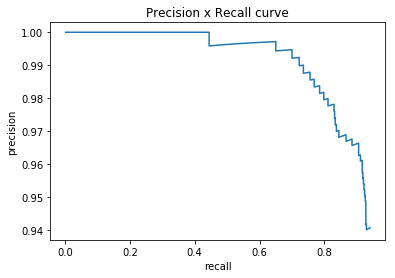

In [119]:
threshold=0.5
gt = updatedData.loc[updatedData['id'].isin(classes)]
sorted_predictions = sort_predictions(frames)
TP_total,FP_total,recalls,precisions,Det_GT_indexes,FP_indexes = analyze_improved(updatedData,sorted_predictions,threshold)
ap, mpre, mrec, ii=CalculateAveragePrecision(recalls, precisions)
result=ElevenPointInterpolatedAP(recalls, precisions)

plt.plot(recalls,precisions)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('Precision x Recall curve')
plt.savefig('prCurve')
print("IoU Thresold:",threshold)
print(TP_total,"true positives")
print(FP_total,"false positives")
print(gt.shape[0]-TP_total,"false negatives")
print("average precision (Every Point Interpolated method):",ap)
print("average precision (11-Points Interpolated method):",result[0])


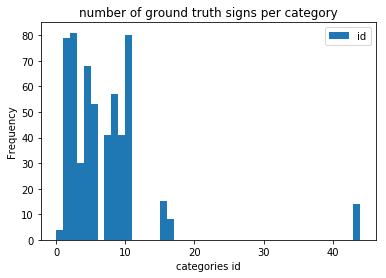

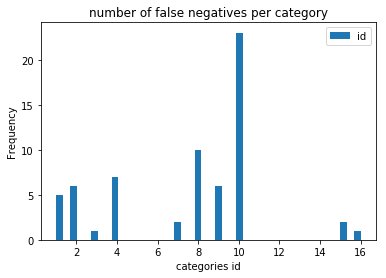

In [101]:
undetected = gt.loc[~gt.index.isin(Det_GT_indexes)]
undetected = undetected.sort_values(by=['id'])

gt[['img','id']].plot.hist(by='id',bins=44)
plt.title('number of ground truth signs per category')
plt.xlabel('categories id')
plt.savefig('nbSigns')
undetected[['img','id']].plot.hist(by='id',bins=44)
plt.title('number of false negatives per category')
plt.xlabel('categories id')
plt.savefig('nbSignsFP')


10th category concentrates a higher frequency of false positives than the other categories.

In [36]:

FP_detections = sorted_predictions.loc[sorted_predictions.index.isin(FP_indexes)].sort_values(
    by=['detection_confidence','img'],ascending=False)
print("False positives sorted by detection confidence:")
print(FP_detections)


False positives sorted by detection confidence:
           img    x1   y1    x2   y2  detection_confidence         class
84   00146.ppm  1201  114  1328  247              0.977745  RedRoundSign
279  00395.ppm   900  518   939  557              0.942657  RedRoundSign
215  00320.ppm   921  401   951  434              0.928424  RedRoundSign
118  00207.ppm  1299  332  1345  374              0.917990  RedRoundSign
397  00616.ppm   876  538   905  568              0.913374  RedRoundSign
17   00039.ppm   909  296   937  326              0.898300  RedRoundSign
177  00276.ppm   544  405   576  428              0.888065  RedRoundSign
119  00207.ppm  1136  367  1169  398              0.874424  RedRoundSign
524  00879.ppm   986  505  1030  545              0.866456  RedRoundSign
192  00295.ppm    99  415   141  464              0.857375  RedRoundSign
193  00295.ppm  1226  362  1273  412              0.832538  RedRoundSign
120  00210.ppm  1209  329  1239  365              0.826637  RedRoundSign
507

We display draw the bounding boxes of the false positives on the images.

In [103]:
import cv2
import os
for i, fp in FP_detections.iterrows():
    im = cv2.imread(os.path.join('FullIJCNN2013',fp.img))
    im_name, file_extension = os.path.splitext(fp.img)
    im = cv2.rectangle(im,(fp.x1,fp.y1),(fp.x2,fp.y2),(0,255,0),3)
    cv2.imwrite(os.path.join('ex2','fp_examples',im_name+'.jpg'),im)